**Proyek Klasifikasi Gambar: A Large Scale Fish Dataset**

*   Nama : Arif Kurniawan
*   Email: mc299d5y1908@student.devacademy.id
*   ID Dicoding: MC299D5Y1908



# **Import Libraries**

In [33]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# **Data Loading**

In [35]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install gdown


In [37]:
import gdown

file_id = '18ERDQ0NtU_nvSqKEMN99I-EKrcDHvmwQ'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, output='dataset.zip', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=18ERDQ0NtU_nvSqKEMN99I-EKrcDHvmwQ
From (redirected): https://drive.google.com/uc?id=18ERDQ0NtU_nvSqKEMN99I-EKrcDHvmwQ&confirm=t&uuid=c6dd8cfb-b3c8-405a-907c-93c766d4501d
To: /content/dataset.zip
100%|██████████| 3.48G/3.48G [00:49<00:00, 70.3MB/s]


'dataset.zip'

In [38]:
# Ekstrak file zip
import zipfile

with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')


In [39]:
# Cek nama kelas
import os

dataset_path = 'dataset'
class_names = os.listdir(dataset_path)
print("Kelas yang ditemukan:", class_names)

Kelas yang ditemukan: ['NA_Fish_Dataset', 'Fish_Dataset_Test', 'Fish_Dataset', 'Segmentation_example_script.m', 'license.txt', 'Fish_Dataset_TrainVal', 'README.txt']


In [43]:


def print_directory_tree(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # tampilkan max 5 file per folder
            print(f"{subindent}{f}")

print_directory_tree("dataset/Fish_Dataset")

Fish_Dataset/
    Fish_Dataset/
        Segmentation_example_script.m
        license.txt
        README.txt
        Red Sea Bream/
            Red Sea Bream/
                00686.png
                00540.png
                00578.png
                00049.png
                00972.png
            Red Sea Bream GT/
                00686.png
                00540.png
                00578.png
                00049.png
                00972.png
        Red Mullet/
            Red Mullet/
                00686.png
                00540.png
                00578.png
                00049.png
                00972.png
            Red Mullet GT/
                00686.png
                00540.png
                00578.png
                00049.png
                00972.png
        Black Sea Sprat/
            Black Sea Sprat/
                00686.png
                00540.png
                00578.png
                00049.png
                00972.png
            Black Sea Sprat GT/
    

# . Data Preprocessing & Split Dataset

In [58]:
# Define the path to the cleaned dataset
cleaned_dataset_path = "Clean_Fish_Dataset"

# Define the target directories for the split data
base_dir = "Final_Fish_Dataset"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create the target directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split the data from Clean_Fish_Dataset into train, val, and test
# Define the split ratios
train_split = 0.7
val_split = 0.15
test_split = 0.15 # The remainder

for class_name in os.listdir(cleaned_dataset_path):
    class_path = os.path.join(cleaned_dataset_path, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        np.random.shuffle(images) # Shuffle the images

        # Calculate split sizes
        num_images = len(images)
        num_train = int(train_split * num_images)
        num_val = int(val_split * num_images)
        # Test takes the rest
        num_test = num_images - num_train - num_val

        # Get subsets of images
        train_images = images[:num_train]
        val_images = images[num_train : num_train + num_val]
        test_images = images[num_train + num_val :]

        # Create class subdirectories in target directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Copy files to their respective directories
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("✅ Dataset split into train, validation, and test sets.")


✅ Dataset split into train, validation, and test sets.


In [63]:
atch_size = 32
img_size = (224, 224)


train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),  # Tetap diperlukan ukuran tetap untuk batch input
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, # Use train_dir here as validation_split applies to the single directory
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    subset=None,
    seed=123,
    image_size=(180, 180),
    batch_size=32
)
class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 6300 files belonging to 9 classes.
Using 5040 files for training.
Found 6300 files belonging to 9 classes.
Using 1260 files for validation.
Found 1350 files belonging to 9 classes.
Number of classes: 9
Class names: ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


# Modelling

In [64]:
from tensorflow.keras import layers, models

# Model CNN Sederhana tapi kuat
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),  # Normalisasi dan definisi input
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # output layer untuk multiclass
])

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan struktur model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
results = model.evaluate(test_ds, batch_size=32)
print("Test loss, test accuracy:", results)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 51200, but received input with shape (None, 86528)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None

# Evaluasi dan Visualisasi

In [65]:
# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 404s 3s/step - accuracy: 0.3509 - loss: 1.9976 - val_accuracy: 0.7579 - val_loss: 0.7230
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.8089 - loss: 0.5514 - val_accuracy: 0.8865 - val_loss: 0.3279
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.9292 - loss: 0.2169 - val_accuracy: 0.9111 - val_loss: 0.2482
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.9701 - loss: 0.0877 - val_accuracy: 0.9063 - val_loss: 0.2806
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.9816 - loss: 0.0577 - val_accuracy: 0.9310 - val_loss: 0.2071


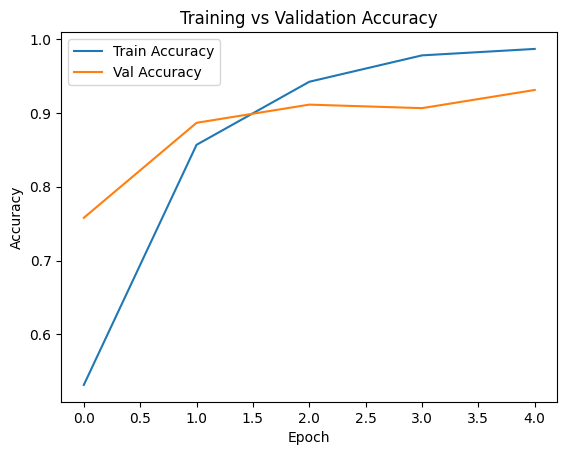

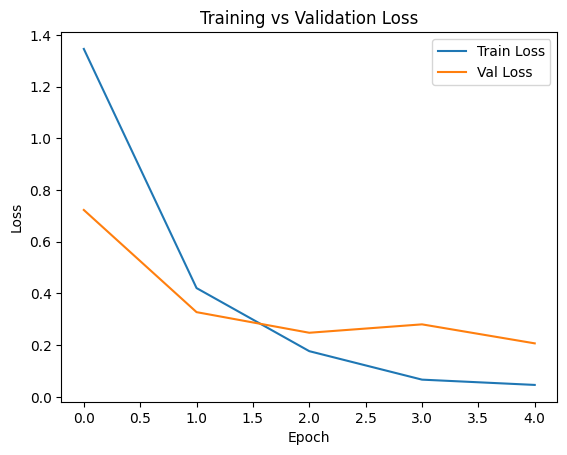

In [66]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


### **Training,Validation dan Testing**

In [67]:
# Evaluasi akhir
train_loss, train_acc = model.evaluate(train_ds)
val_loss, val_acc = model.evaluate(val_ds)
print(f"Akurasi Training: {train_acc*100:.2f}%")
print(f"Akurasi Validasi: {val_acc*100:.2f}%")

158/158 ━━━━━━━━━━━━━━━━━━━━ 149s 933ms/step - accuracy: 0.9957 - loss: 0.0188
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 969ms/step - accuracy: 0.9149 - loss: 0.2129
Akurasi Training: 99.60%
Akurasi Validasi: 93.10%


In [68]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100: .2f}%")

43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 787ms/step - accuracy: 0.9396 - loss: 0.1765
Test Accuracy:  94.81%


###**Membuat Folder pada Drive untuk menyimpan save_model, tflite dan tfjs**

In [95]:
import os

base_path = '/content/drive/MyDrive/Proyek_Ikan_Klasifikasi'

saved_model_path = os.path.join(base_path, 'saved_model')
tflite_model_path = os.path.join(base_path, 'model.tflite')
tfjs_model_path = os.path.join(base_path, 'model_tfjs')

os.makedirs(saved_model_path, exist_ok=True)
os.makedirs(tfjs_model_path, exist_ok=True)


In [98]:
# Path file model
# Menggunakan base_path yang sudah didefinisikan sebelumnya
model_keras_path = os.path.join(base_path, 'my_model.keras')
# saved_model_path sudah didefinisikan di cell sebelumnya, tapi kita definisikan ulang agar jelas
saved_model_path = os.path.join(base_path, 'saved_model')
# tflite_model_path sudah didefinisikan di cell sebelumnya, tapi kita definisikan ulang agar jelas
tflite_model_path = os.path.join(base_path, 'model.tflite')
# Definisikan path untuk label.txt di dalam base_path
label_txt_path = os.path.join(base_path, 'label.txt')

# Simpan model ke format .keras
model.save(model_keras_path)
# Simpan model ke format SavedModel menggunakan model.export()
model.export(saved_model_path)

# Konversi ke TFLite dari model .keras
converter = tf.lite.TFLiteConverter.from_keras_model(tf.keras.models.load_model(model_keras_path))
tflite_model = converter.convert()

# Simpan TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Simpan label.txt
with open(label_txt_path, 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

print(" Model dan label berhasil disimpan di folder Google Drive:")
print(f" {model_keras_path}")
print(f" {saved_model_path}")
print(f" {tflite_model_path}")
print(f" {label_txt_path}")

Saved artifact at '/content/drive/MyDrive/Proyek_Ikan_Klasifikasi/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  134878539866448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878537225360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878537226320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878537226896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878537226128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878537227664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878537224976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878537228624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878537228048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134878537229392: TensorSpec(shape=(), dty

In [99]:
!pip install tensorflowjs
import tensorflowjs as tfjs

# Simpan model ke format TFJS
tfjs_target_dir = os.path.join(base_path, 'model_tfjs')
tfjs.converters.save_keras_model(tf.keras.models.load_model(model_keras_path), tfjs_target_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


# Inference

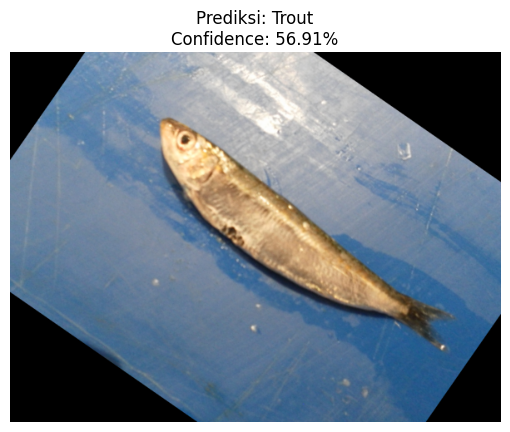

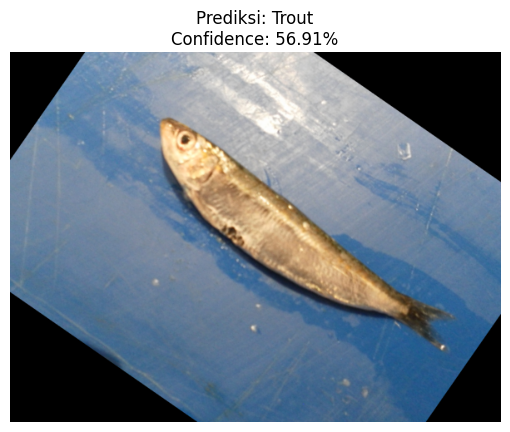

In [104]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import os

# Ganti path gambar sesuai yang kamu ingin uji
img_path = 'dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00002.png'

try:
    # Load gambar
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((180, 180))
    img_array = np.array(img_resized, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Load model TFLite dari Google Drive
    interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Proyek_Ikan_Klasifikasi/model.tflite")
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']

    interpreter.set_tensor(input_index, img_array)
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    predicted_class_index = np.argmax(output)
    confidence = np.max(output) * 100

    # Periksa class_names
    if 'class_names' in globals() and predicted_class_index < len(class_names):
        predicted_class = class_names[predicted_class_index]
    else:
        predicted_class = f"Kelas tidak diketahui (Index: {predicted_class_index})"
        if 'class_names' not in globals():
            print(" Warning: 'class_names' is not defined. Pastikan cell sebelumnya sudah dijalankan.")

    # Visualisasi hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=12)
    plt.show()

except FileNotFoundError:
    print(f" Error: Gambar tidak ditemukan di path {img_path}.")
except Exception as e:
    print(f" Terjadi kesalahan: {e}")
import tensorflow as tf
import os

# Ganti path gambar sesuai yang kamu ingin uji
img_path = 'dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00002.png'

try:
    # Load gambar
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((180, 180))
    img_array = np.array(img_resized, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Load model TFLite dari Google Drive
    interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Proyek_Ikan_Klasifikasi/model.tflite")
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']

    interpreter.set_tensor(input_index, img_array)
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    predicted_class_index = np.argmax(output)
    confidence = np.max(output) * 100

    # Periksa class_names
    if 'class_names' in globals() and predicted_class_index < len(class_names):
        predicted_class = class_names[predicted_class_index]
    else:
        predicted_class = f"Kelas tidak diketahui (Index: {predicted_class_index})"
        if 'class_names' not in globals():
            print(" Warning: 'class_names' is not defined. Pastikan cell sebelumnya sudah dijalankan.")

    # Visualisasi hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=12)
    plt.show()

except FileNotFoundError:
    print(f" Error: Gambar tidak ditemukan di path {img_path}.")
except Exception as e:
    print(f" Terjadi kesalahan: {e}")


In [105]:
!pip freeze > requirements.txt


In [106]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>